In [96]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn
import scipy
import mne
import os
import pandas as pd
import numpy as np
import mne
import scipy

class NoValidTroughException(Exception):
    pass

class Waveform_analyzer:
    
    def __init__(self, sample_rate=1000, line_noise=60, bp_low_cutoff=5, bp_high_cutoff=90):
        self.sample_rate = sample_rate
        self.line_noise = line_noise
        self.filter = mne.filter.create_filter(None, sample_rate, l_freq=bp_low_cutoff, h_freq=bp_high_cutoff, 
                                fir_design='firwin', l_trans_bandwidth=5, 
                                h_trans_bandwidth=5, filter_length='1000ms')
    
    def get_peaks_around(self, trough_ind, arr_ind_peaks, filtered_dat):

        # find all peaks to the right (then left) side, then take the closest one to the trough
        ind_greater = np.where(arr_ind_peaks>trough_ind)[0]
        if ind_greater.shape[0] == 0:
            raise NoValidTroughException("No valid trough")
        val_ind_greater = arr_ind_peaks[ind_greater]
        peak_right_idx = arr_ind_peaks[ind_greater[np.argsort(val_ind_greater)[0]]]

        ind_smaller = np.where(arr_ind_peaks<trough_ind)[0]
        if ind_smaller.shape[0] == 0:
            raise NoValidTroughException("No valid trough")

        val_ind_smaller = arr_ind_peaks[ind_smaller]
        peak_left_idx = arr_ind_peaks[ind_smaller[np.argsort(val_ind_smaller)[-1]]]

        return peak_left_idx, peak_right_idx, filtered_dat[peak_left_idx], filtered_dat[peak_right_idx]

    def analyze_waveform(self, raw_dat, peak_dist=1, trough_dist=5, label=False, y_contra=None, y_ipsi=None):
        
        # first notch filter data 
        dat_notch_filtered = mne.filter.notch_filter(x=raw_dat, Fs=self.sample_rate, trans_bandwidth=7,
            freqs=np.arange(self.line_noise, 4*self.line_noise, self.line_noise),
            fir_design='firwin', verbose=False, notch_widths=1,filter_length=raw_dat.shape[0]-1)

        filtered_dat = scipy.signal.convolve(dat_notch_filtered, self.filter, mode='same')

        peaks = scipy.signal.find_peaks(filtered_dat, distance=peak_dist)[0]
        troughs = scipy.signal.find_peaks(-filtered_dat, distance=trough_dist)[0]
        
        df  = pd.DataFrame()
        sharp_wave = {}
        for trough_idx in troughs:
            try:
                peak_idx_left, peak_idx_right, peak_left, peak_right = self.get_peaks_around(trough_idx, 
                                                                                        peaks, filtered_dat)
            except NoValidTroughException as e:
                # in this case there is no adjacent two peaks around this trough
                print(str(e))
                continue

            # interval 
            if df.shape[0]>0:
                interval_ = (trough_idx - sharp_wave["trough_idx"]) * (1000/self.sample_rate)
            else:
                # set first interval to zero 
                interval_ = 0

            # sharpness
            if (trough_idx - int(5*(1000/self.sample_rate)) < 0) or \
                (trough_idx + int(5*(1000/self.sample_rate)) > filtered_dat.shape[0]): 
                continue
            # convert 5 ms to sample rate 
            sharpness = (filtered_dat[trough_idx-int(5*(1000/self.sample_rate))] + 
                         filtered_dat[trough_idx+int(5*(1000/self.sample_rate))]) / 2

            # rise_steepness, first der. from trough to peak 
            # here  + 1 due to python syntax, s.t. the last element is included
            rise_steepness = np.max(np.diff(filtered_dat[peak_idx_left : trough_idx+1]))

            # decay_steepness
            decay_steepness = np.max(np.diff(filtered_dat[trough_idx : peak_idx_right+1]))

            sharp_wave  = {
                "peak_left" : peak_left, 
                "peak_right" : peak_right,
                "peak_idx_left" : peak_idx_left,
                "peak_idx_right" : peak_idx_right,
                "trough" : filtered_dat[trough_idx], # mV
                "trough_idx" : trough_idx,
                "width" : peak_idx_right - peak_idx_left, # ms 
                "prominence": np.abs((peak_right + peak_left) / 2 - filtered_dat[trough_idx]), # mV
                "interval" : interval_, # ms
                "decay_time": (peak_idx_left - trough_idx) *(1000/self.sample_rate),
                "rise_time" : (peak_idx_right - trough_idx) *(1000/self.sample_rate),
                "sharpness" : sharpness,
                "rise_steepness" : rise_steepness, 
                "decay_steepness" : decay_steepness,
                "slope_ratio" : rise_steepness - decay_steepness, 
                "label" : False, 
                "MOV_TYPE" : None, 
                "y_contra" : None,
                "y_ipsi" : None
            }
            
            if label is True: 
                sharp_wave["label"] = True
                    # movement
                if y_ipsi[trough_idx] > 0:
                    MOV_ = "IPS"
                elif y_contra[trough_idx] > 0:
                    MOV_ = "CON"
                else:
                    MOV_ = "NONE"
                sharp_wave["MOV_TYPE"] = MOV_
                sharp_wave["y_contra"] = y_contra[trough_idx] 
                sharp_wave["y_ipsi"] = y_ipsi[trough_idx]
            df = df.append(sharp_wave, ignore_index=True)
        return df 

In [75]:
# examplary try: read one run file and add the resp. features... actually it's a dataframe
# but here POC: analyze whole run 

In [76]:
raw = mne.io.read_raw_brainvision('C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\sub-000\\ses-right\\ieeg\\sub-000_ses-right_task-force_run-0_ieeg.vhdr')

Extracting parameters from C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-0_ieeg.vhdr...
Setting channel info structure...


In [98]:
waveform_analyzer = Waveform_analyzer(sample_rate=1000, line_noise=60)

No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-pass filter from 5 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 2.50 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 92.50 Hz)
- Filter length: 1001 samples (1.001 sec)



In [99]:
raw.get_data().shape

(10, 130001)

In [100]:
raw.ch_names

['ECOG_RIGHT_0',
 'ECOG_RIGHT_1',
 'ECOG_RIGHT_2',
 'ECOG_RIGHT_3',
 'ECOG_RIGHT_4',
 'ECOG_RIGHT_5',
 'MOV_RIGHT',
 'MOV_LEFT',
 'MOV_RIGHT_CLEAN',
 'MOV_LEFT_CLEAN']

In [101]:
df = waveform_analyzer.analyze_waveform(raw.get_data()[5,:], peak_dist=1, trough_dist=5, 
                        label=True, y_contra=raw.get_data()[9,:], y_ipsi=raw.get_data()[8,:])

In [69]:
def plot_mov_sep_hist(metric, label):
    sn.distplot(df[df.MOV_TYPE.str.contains("NONE")][metric], label='None', color='black')
    sn.distplot(df[df.MOV_TYPE.str.contains("CON")][metric], label='CON', color='red')
    sn.distplot(df[df.MOV_TYPE.str.contains("IPS")][metric], label='IPS', color='blue')
    plt.title(metric)
    plt.xlabel(metric + " [" + label+"]")
    plt.legend()

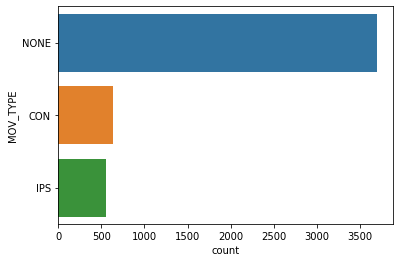

In [130]:
sn.countplot(y="MOV_TYPE", data = df)

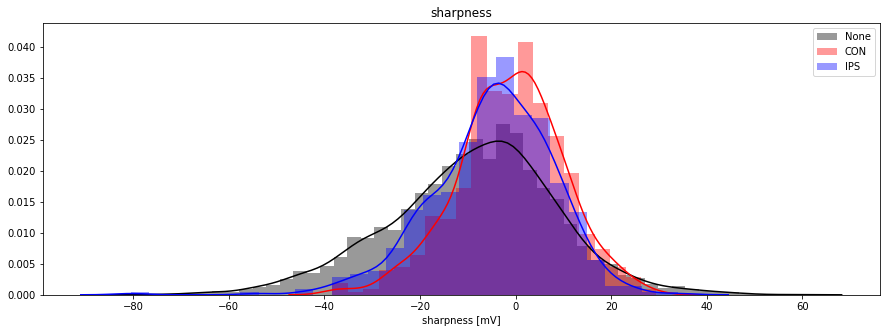

In [70]:
plt.figure(figsize=(15,5))
plot_mov_sep_hist("sharpness", "mV")

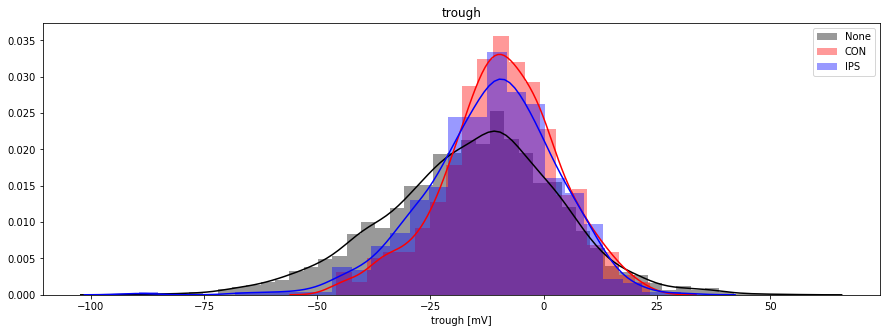

In [71]:
plt.figure(figsize=(15,5))
plot_mov_sep_hist("trough", "mV")

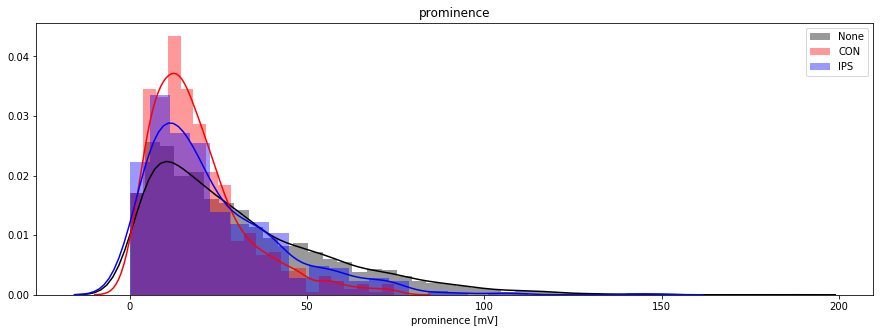

In [132]:
plt.figure(figsize=(15,5))
plot_mov_sep_hist("prominence", "mV")

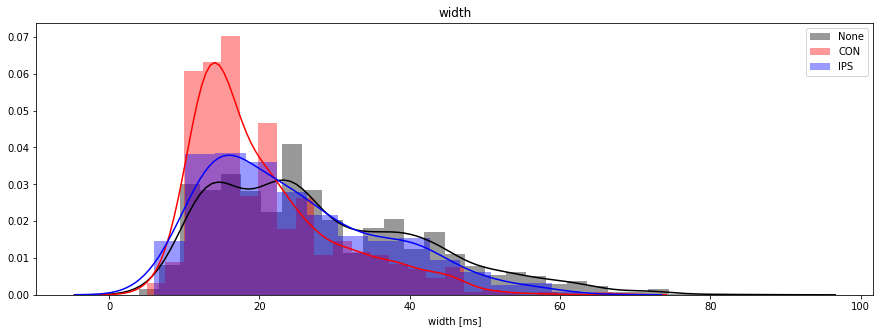

In [133]:
plt.figure(figsize=(15,5))
plot_mov_sep_hist("width", "ms")

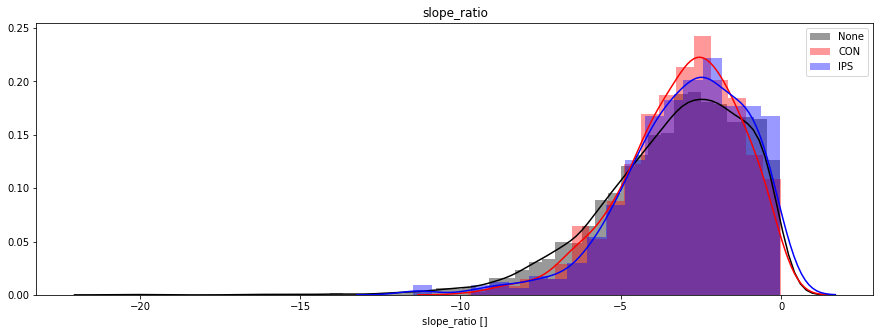

In [134]:
plt.figure(figsize=(15,5))
plot_mov_sep_hist("slope_ratio", "")

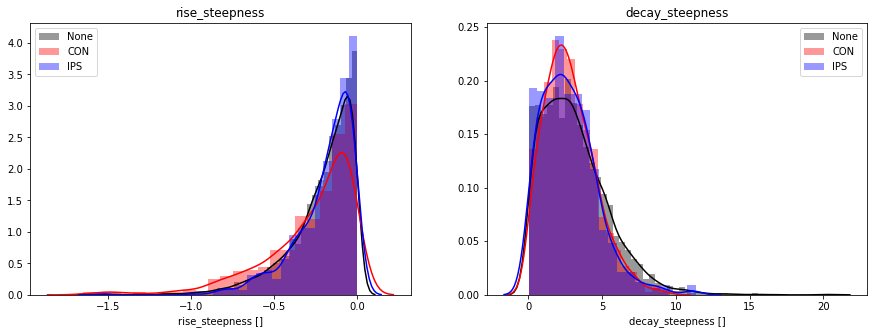

In [135]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plot_mov_sep_hist("rise_steepness", "")
plt.subplot(122)
plot_mov_sep_hist("decay_steepness", "")

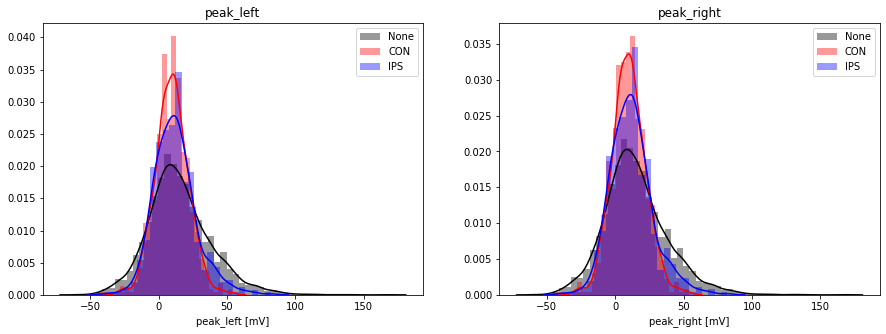

In [136]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plot_mov_sep_hist("peak_left", "mV")
plt.subplot(122)
plot_mov_sep_hist("peak_right", "mV")

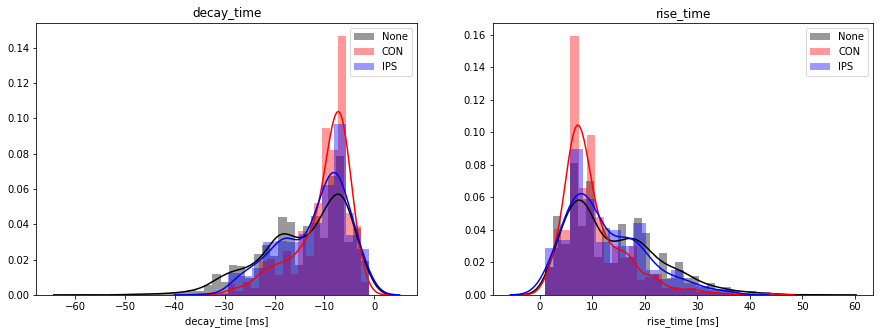

In [137]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plot_mov_sep_hist("decay_time", "ms")
plt.subplot(122)
plot_mov_sep_hist("rise_time", "ms")

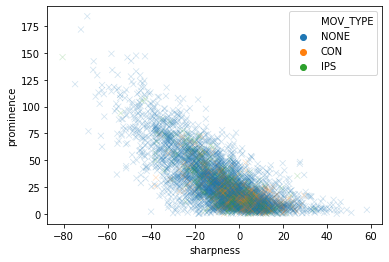

In [128]:
sn.scatterplot(x = "sharpness", y="prominence", hue="MOV_TYPE", data = df, alpha=0.2, marker='x')

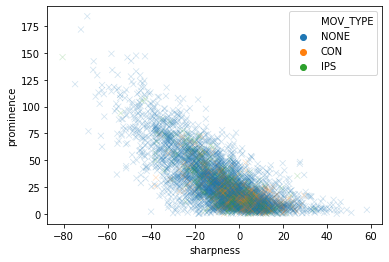

In [117]:
sn.scatterplot(x = "sharpness", y="prominence", hue="MOV_TYPE", data = df, alpha=0.2, marker='x')

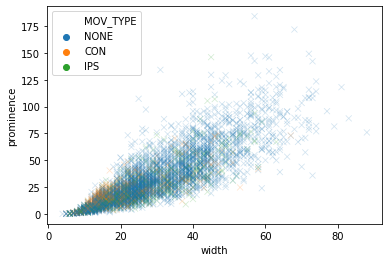

In [119]:
sn.scatterplot(x = "width", y="prominence", hue="MOV_TYPE", data = df, alpha=0.2, marker='x')

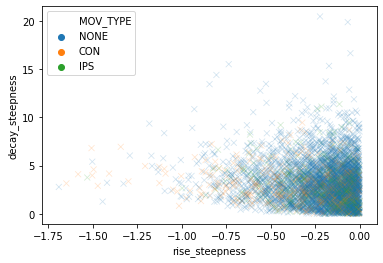

In [121]:
sn.scatterplot(x = "rise_steepness", y="decay_steepness", hue="MOV_TYPE", data = df, alpha=0.2, marker='x')

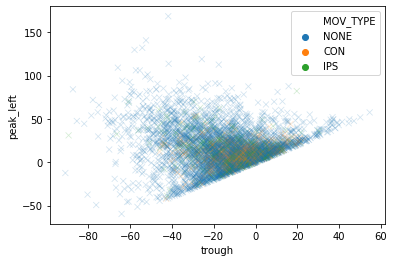

In [126]:
sn.scatterplot(x = "trough", y="peak_left", hue="MOV_TYPE", data = df, alpha=0.2, marker='x')

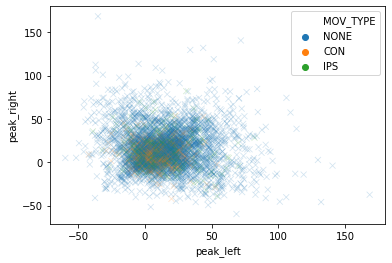

In [127]:
sn.scatterplot(x = "peak_left", y="peak_right", hue="MOV_TYPE", data = df, alpha=0.2, marker='x')

In [120]:
df.keys()

Index(['MOV_TYPE', 'decay_steepness', 'decay_time', 'interval', 'label',
       'peak_idx_left', 'peak_idx_right', 'peak_left', 'peak_right',
       'prominence', 'rise_steepness', 'rise_time', 'sharpness', 'slope_ratio',
       'trough', 'trough_idx', 'width', 'y_contra', 'y_ipsi'],
      dtype='object')

In [ ]:
# primary goal here: what is the characterization of movement wrt sharp waves? 
# are they different wrt to the given location? 
# how well can we use those features? and then more important what are they? 

# Literature search: Sharpwaves wrt to movement 